# Automatic Image Captioning for Visually Impaired People

# Importing the libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import tensorflow as tf
import string
import os
import glob
import cv2
from numpy import array
from PIL import Image
from wordcloud import WordCloud 
from time import time
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.preprocessing import image
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.utils import to_categorical
from keras import Input, layers, optimizers
from keras.layers import LSTM, Embedding, Dense, Activation,Flatten, Reshape,Dropout,concatenate,BatchNormalization
from keras.layers.merge import add
from keras.models import Model
from keras.optimizers import Adam
from nltk.translate.bleu_score import corpus_bleu
from collections import OrderedDict
from gtts import gTTS

Using TensorFlow backend.


# Data Pre-processing

Reading the token files and displaying the format of the token file

In [2]:
token_file = "../Image Captioning Material/visually_impaired_dataset/visuallyimpair/visual_text/visual.token.txt"
token_doc = open(token_file, 'r')
token_doc = token_doc.read()
print(token_doc[-212:])

playing50.jpg#1	Kids are sitting in the park .
playing50.jpg#2	Kids are sitting in the garden .
playing50.jpg#3	Group of kids sitting in the park .
playing50.jpg#4	Group of kids sitting and playing in the park .	


Creating the dictionary from the token files (key as Image name and Values as relevant tokens each image).

In [3]:
caption = dict()
for desc in token_doc.split('\n'):
    image_name = desc.split()[0].split('.')[0]
    image_caption = ' '.join(desc.split()[1:])
    if image_name not in caption:
        caption[image_name] = list()
    caption[image_name].append(image_caption)
print('Length of the Dictionary: %d ' % len(caption))

Length of the Dictionary: 1600 


Checking whether both the keys and values are properly appened into the dictionary

In [4]:
keys = list(caption.keys())[80:85]
values = list(caption.values())[80]
print("Description of Keys:",keys)
print("Description of Values:", values)

Description of Keys: ['push24', 'push25', 'push26', 'push27', 'push28']
Description of Values: ['Push button ahead press to walk .', 'There is a push button ahead of you .', 'Please find the push button ahead .', 'There is a push button ahead .', 'Please press the push button ahead of you .']


Converting all the captions to the lower case and removing all the punctuations

In [5]:
table = str.maketrans('', '', string.punctuation)
for cap in caption:
    val= caption[cap]
    for i in range(len(val)):
        val[i]=val[i].lower()
    val = [w.translate(table) for w in val]
    caption[cap]=val 

In [6]:
for key, desc_list in caption.items():
    print(key)
    print(desc_list)
    break

greensig1
['green signal please walk ', 'green signal please walk ', 'green signal please walk ', 'green signal please walk ', 'green signal please walk ']


Creating the unique vocabulary out of all the captions

In [7]:
vocabulary = set()
for key in caption.keys():
    for cap in caption[key]:
        vocabulary.update(cap.split())
print('Original Vocabulary Size of the Captions:',len(vocabulary))

Original Vocabulary Size of the Captions: 147


Saving the captions along with the image name

In [8]:
caption_file = 'caption_file.txt'
cap_file = open(caption_file, 'w')
each_line=[ key + ' ' + desc for key,desc_list in caption.items() for desc in desc_list] 
cap_file.write('\n'.join(each_line))
cap_file.close()

Load the train files

In [9]:
train_path = '../Image Captioning Material/visually_impaired_dataset/visuallyimpair/visual_text/visual.trainImages.txt'
train_doc = open(train_path, 'r')
train_doc = train_doc.read()

train_name = list()
for train_img in train_doc.split('\n'):
    train_name.append(train_img.split('.')[0])
print('Length of the Train Images in the dataset:',len(train_name))


Length of the Train Images in the dataset: 1200


Load the test files

In [10]:
test_path = '../Image Captioning Material/visually_impaired_dataset/visuallyimpair/visual_text/visual.testImages.txt'
test_doc = open(test_path, 'r')
test_doc = test_doc.read()

test_name = list()
for test_img in test_doc.split('\n'):
    test_name.append(test_img.split('.')[0])
print('Length of the Test Images in the dataset:',len(test_name))

Length of the Test Images in the dataset: 400


Loading all the images present in the visual dataset path using glob 

In [11]:
images_path = '../Image Captioning Material/visually_impaired_dataset/visuallyimpair/visual_dataset/'
image_glb = glob.glob(images_path + '*.jpg')
print(image_glb[0:5])

['../Image Captioning Material/visually_impaired_dataset/visuallyimpair/visual_dataset\\ATM1.jpg', '../Image Captioning Material/visually_impaired_dataset/visuallyimpair/visual_dataset\\ATM10.jpg', '../Image Captioning Material/visually_impaired_dataset/visuallyimpair/visual_dataset\\ATM11.jpg', '../Image Captioning Material/visually_impaired_dataset/visuallyimpair/visual_dataset\\ATM12.jpg', '../Image Captioning Material/visually_impaired_dataset/visuallyimpair/visual_dataset\\ATM13.jpg']


Load train images present in the dataset

In [12]:
train_doc1 = set(open(train_path, 'r').read().strip().split('\n'))

train_image_name=[train_name1 for train_name1 in image_glb if train_name1[len(images_path):] in
                  train_doc1]
print('Length of the train images matches with the Visual Dataset Images:',len(train_image_name))

Length of the train images matches with the Visual Dataset Images: 1200


Load test images present in the dataset

In [13]:
test_doc1 = set(open(test_path, 'r').read().strip().split('\n'))

test_image_name = [test_name1 for test_name1 in image_glb if test_name1[len(images_path):] 
                   in test_doc1]
print('Length of the train images matches with the Visual Dataset Images:',len(test_image_name))

Length of the train images matches with the Visual Dataset Images: 400


Append 'startseq' and 'endseq' to each caption present in the train file

In [14]:
caption_doc = open(caption_file, 'r')
caption_doc = caption_doc.read()

train_image_description =  dict()
for train_caption in caption_doc.split('\n'):
    image_name = train_caption.split()[0]
    image_caption = train_caption.split()[1:]
    if image_name in train_name:
        if image_name not in train_image_description:
            train_image_description[image_name] = list()
        description = 'startseq ' + ' '.join(image_caption) + ' endseq'
        train_image_description[image_name].append(description)
    
print('Length of Caption Description in Train:',len(train_image_description))

Length of Caption Description in Train: 1200


# Unit Testing: Considering all the discrepancies while creating the Visual Assistance Dataset

To check if any of the captions are missing in the caption file (visual.token.txt) with respect to the train (visual.trainImages.txt) and test (visual.testImages.txt) text files. 

In [15]:
if len(train_name) + len(test_name) == len(caption.keys()):
    print("All instances splitted in train and test with respect to formed dictionary: PASS")
else:
    dataset_images= list(caption.keys())
    print("All instances splitted in train and test with respect to formed dictionary: FAIL")
    print("Missing Records: ")
    for data_img in dataset_images:
        if ((data_img not in train_name) and (data_img not in test_name)):
            print(data_img)

All instances splitted in train and test with respect to formed dictionary: PASS


Test 2: As each image associated with the five different captions, check if any of the captions are missing for those images which are present in the dataset.

In [16]:
flag=0
for name in caption.keys():
    if len(caption[name])!=5:
        print("Missing image caption ",name)
        flag=1
    
if flag==0:
    print("All images have five corresponding captions: PASS")
else:
    print("All images have five corresponding captions: FAIL")

All images have five corresponding captions: PASS


Test 3: To check if any of the images missing in the dataset with respect to the train (visual.trainImages.txt) and test (visual.testImages.txt) text files. 

In [17]:
if len(train_name) +len(test_name)== len(image_glb):
    print("All instances splitted in train and test with respect to image dataset: PASS")
else:
    dataset_images_all=[]
    for i in image_glb:
        dataset_images_all.append(i[len(images_path):].split(".")[0])
    total_name = train_name + test_name
    for name in total_name:
        if name not in dataset_images_all:
            print(name)
        
    print("All instances splitted in train and test with respect to image dataset: FAIL")

All instances splitted in train and test with respect to image dataset: PASS


# Data Visualisation

Caption Length Distribution

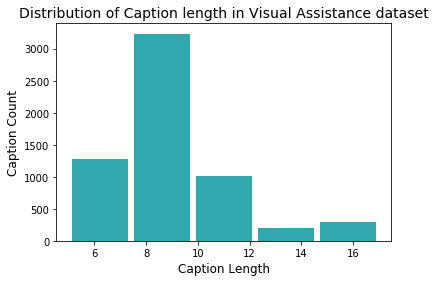

In [18]:
cap_len = []
for key in train_image_description.keys():
    for j in range(0,5):
        try:
            cap_len.append(len(train_image_description[key][j].split(" ")))
        except:
            print(key)

cap_graph = pd.Series(cap_len)
cap_graph.plot(kind='hist',bins= 5, rwidth=0.9, color = '#32a7ad')
plt.xlabel("Caption Length", fontsize=12)
plt.ylabel("Caption Count",fontsize=12)
plt.title("Distribution of Caption length in Visual Assistance dataset",fontsize=14)
plt.savefig('Caption_Length.png')

Visualising the top 15 words in the vocabulary

In [19]:
cap_vocab = list(caption.values())
my_list=[]
flattened_list = [y for x in cap_vocab for y in x]
for f in flattened_list:
    words=f.split()
    for word in words: 
        my_list.append(word)

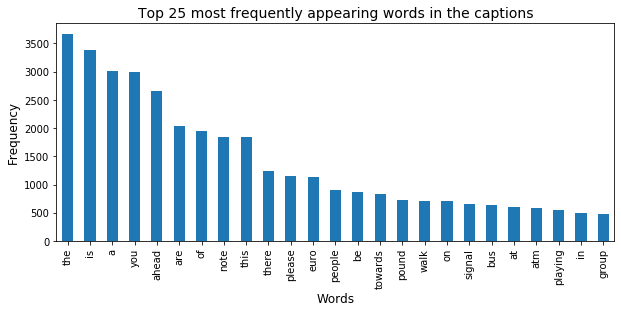

In [20]:
plt.figure(figsize=(10,4))
Caption_graph = pd.Series(my_list).value_counts().head(25).plot(kind='bar')
plt.xlabel("Words", fontsize=12)
plt.ylabel("Frequency",fontsize=12)
plt.title("Top 25 most frequently appearing words in the captions",fontsize=14)
plt.savefig('Top 25 words.png')

Visualising the least 15 words in the vocabulary

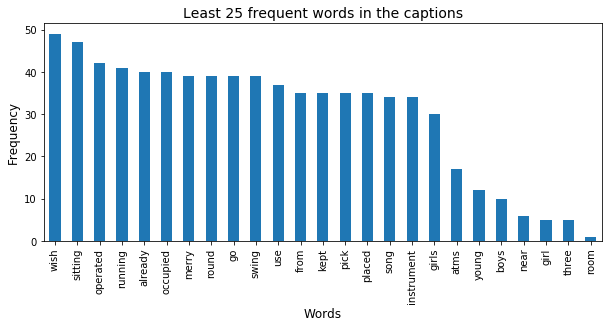

In [21]:
plt.figure(figsize=(10,4))
Caption_graph = pd.Series(my_list).value_counts().tail(25).plot(kind='bar')
plt.xlabel("Words", fontsize=12)
plt.ylabel("Frequency",fontsize=12)
plt.title("Least 25 frequent words in the captions",fontsize=14)
plt.savefig('Least 25 words.png')

Word cloud representing the most important words

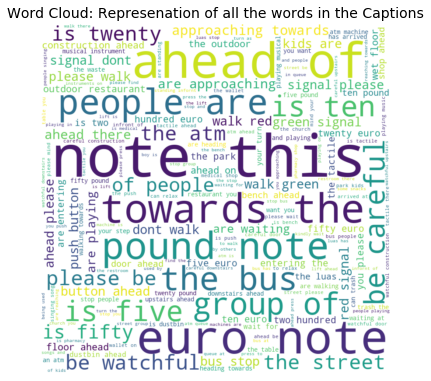

In [22]:
wordcloud = WordCloud(width = 800, height = 800, min_font_size = 10,
                background_color ='white').generate(" ".join(my_list)) 
  
# plot the WordCloud image                        
plt.figure(figsize = (6,6), facecolor = None) 
plt.title("Word Cloud: Represenation of all the words in the Captions",fontsize=14)
plt.axis("off") 
plt.imshow(wordcloud, interpolation ='bilinear') 
plt.tight_layout(pad = 0) 
plt.show() 
wordcloud.to_file("Word Cloud.png")

# Pre-processing the image size by inception v3 model

Loading the inception v3 model to get 2048 feature vectors:
      * converting the images into the size of 299X299 
      * removing the last outputlayer from the inception v3


In [23]:
inception_model = InceptionV3(weights='imagenet')
new_model = Model(inception_model.input, inception_model.layers[-2].output)

In [24]:
def encode_image(image_path):
    target_img = image.load_img(image_path, target_size=(299, 299))
    trgt_size = np.expand_dims(image.img_to_array(target_img), axis=0)
    trgt_size = preprocess_input(trgt_size)
    feature_vector = new_model.predict(trgt_size) 
    feature_vector = np.reshape(feature_vector, feature_vector.shape[1]) 
    return feature_vector

Creating the training and testing encoded features

In [25]:
encode_train_image = {}
encode_test_image = {}
size = len(images_path)
for img in train_image_name:
    encode_train_image[img[size:]] = encode_image(img)

for img in test_image_name:
    encode_test_image[img[size:]] = encode_image(img)

Creating a vocabulary for the captions after adding start and end sequences

In [26]:
vocabulary = set()
for key in train_image_description.keys():
    for cap in train_image_description[key]:
        vocabulary.update(cap.split())
print('Original Vocabulary Size of the Captions:',len(vocabulary))

Original Vocabulary Size of the Captions: 147


Mapping the words to index and index to words

In [27]:
index = 1
wordtoindex = {}
indextoword = {}
for w in vocabulary:
    wordtoindex[w] = index
    index = index + 1

index=1
for w in vocabulary:
    indextoword[index] = w
    index = index + 1

In [28]:
vocabulary_size = len(indextoword) + 1
print('The size of the vocabulary:',vocabulary_size)

The size of the vocabulary: 148


In [29]:
train_desc = list()
for key in train_image_description.keys():
    for desc in train_image_description[key]:
        train_desc.append(desc)
        
max_len=[]
for desc in train_desc:
    max_len.append(len(desc.split()))

mx_lng=max(max_len)
print('Maximum sequence length in train descriptions:',mx_lng)

Maximum sequence length in train descriptions: 17


Created a Generator Function to predict the next word from the partial sequences and feature vector

In [30]:
def caption_generator(caption, photos, number_of_photos_each_batch):
    z=0
    imgs = list()
    in_seq_list = list()
    out_seq_list = list()
    
    while True:
        for key, desc_list in caption.items():
            z = z+1
            key_name = key + '.jpg'
            photo = photos[key_name]
            sequence = []
            for descrp in desc_list:
                for word in descrp.split():
                    if word in wordtoindex:
                        sequence.append(wordtoindex[word])
                        
                for i in range(1, len(sequence)):
                    imgs.append(photo)
                    in_seq_element = sequence[:i]
                    in_seq_element = pad_sequences([in_seq_element], mx_lng)[0]
                    in_seq_list.append(in_seq_element)

                    out_seq_element= sequence[i]
                    out_seq_element = to_categorical([out_seq_element], vocabulary_size)[0]                   
                    out_seq_list.append(out_seq_element)
            
            if z == number_of_photos_each_batch:
                yield [[array(imgs), array(in_seq_list)], array(out_seq_list)]
                imgs= list()
                in_seq_list = list()
                out_seq_list = list() 
                z=0

The pre-trained GloVe model is used to get the embedding for all the words in the vocabulary.

In [31]:
emb_file = open(os.path.join('../Image Captioning Material/', 'glove.6B.200d.txt'), encoding="utf-8")
emb_index = {} 
for line in emb_file:
    values = line.split()
    emb_index[values[0]] = np.asarray(values[1:], dtype='float32')
emb_file.close()
print('The embedding file consists of %s word vectors.' % len(emb_index))

The embedding file consists of 400000 word vectors.


In [32]:
emb_matrix = np.zeros((vocabulary_size, 200))

for word, i in wordtoindex.items():
    if emb_index.get(word) is not None:
        emb_matrix[i] = emb_index.get(word)
emb_matrix.shape

(148, 200)

# Merge Model Implementation

Create a Merge Model using the Keras functional API:

There are two inputs:
            * Feature vector of length 2048
            * Embedded word vectors of vocabulary word

Model Hyperparameters:
            * Dropout = 0.5
            * LSTM: 256 Units
            * Dense Layer 256 Nodes
            * Activation : relu

In [33]:
inp_layer_cnn = Input(shape=(2048,))
inp_hidden1 = Dropout(0.5)(inp_layer_cnn)
inp_hidden2 = Dense(256, activation='relu')(inp_hidden1)

In [34]:
inp_layer_lstm = Input(shape=(mx_lng,))
inp_lstm_hidden1 = Embedding(vocabulary_size, 200, mask_zero=True)(inp_layer_lstm)
inp_lstm_hidden2 = Dropout(0.5)(inp_lstm_hidden1)
inp_lstm_hidden3 = LSTM(256)(inp_lstm_hidden2)

Combining both the inputs using keras add utility function

In [35]:
comb_inp = add([inp_hidden2, inp_lstm_hidden3])
final_comb = Dense(256, activation='relu')(comb_inp)
output_model = Dense(vocabulary_size, activation='softmax')(final_comb)
merge_model = Model(inputs = [inp_layer_cnn, inp_layer_lstm], outputs = output_model)

In [36]:
merge_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 17)           0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 2048)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 17, 200)      29600       input_3[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 2048)         0           input_2[0][0]                    
____________________________________________________________________________________________

In [37]:
merge_model.layers[2]

To avoid updation of weights in the back propagation: Set the trainable to False

In [38]:
merge_model.layers[2].set_weights([emb_matrix])
merge_model.layers[2].trainable = False

In [39]:
merge_model.compile(loss='categorical_crossentropy', optimizer='adam')

Cutomised function to adjust the Hyperparameter for the Model:
                * Number of Epochs
                * Number of pic per Batch
                * Learning Rate
                * Step Size

In [40]:
def model_implement(epochs,no_pics_per_batch,lr,steps):
    merge_model.optimizer.learning_rate=lr
    losses=[]

    for i in range(epochs):
        model_generator = caption_generator(train_image_description, encode_train_image, no_pics_per_batch)
        history=merge_model.fit_generator(model_generator, epochs=1,steps_per_epoch= steps, verbose=1)
        print(history.history.keys())
        losses.append(history.history['loss'])
        print("********* Current epoch **********",i) 
        try:
            merge_model.save('./merge_model_thesis_weights_08/model_' + str(i) + '.h5')
        except:
            print('Saved')
            pass
    
    return losses

Running the initial epochs with:
                    * Number of Epochs: 40
                    * Number of pic per Batch: 3
                    * Learning Rate: 0.001
                    * Step Size : 400

In [41]:
loss_vals_first = model_implement(40,3,0.0001,len(train_image_description)//3)

Epoch 1/1
400/400 [==============================] - 56s 141ms/step - loss: 3.9626
dict_keys(['loss'])
********* Current epoch ********** 0
Saved
Epoch 1/1
400/400 [==============================] - 78s 196ms/step - loss: 2.8166
dict_keys(['loss'])
********* Current epoch ********** 1
Saved
Epoch 1/1
400/400 [==============================] - 78s 196ms/step - loss: 2.0200
dict_keys(['loss'])
********* Current epoch ********** 2
Saved
Epoch 1/1
400/400 [==============================] - 78s 196ms/step - loss: 1.5082
dict_keys(['loss'])
********* Current epoch ********** 3
Saved
Epoch 1/1
400/400 [==============================] - 78s 196ms/step - loss: 1.1604
dict_keys(['loss'])
********* Current epoch ********** 4
Saved
Epoch 1/1
400/400 [==============================] - 78s 196ms/step - loss: 0.9085
dict_keys(['loss'])
********* Current epoch ********** 5
Saved
Epoch 1/1
400/400 [==============================] - 78s 196ms/step - loss: 0.7259
dict_keys(['loss'])
********* Current epo

Observing the loss over the Set 1 Epochs

In [42]:
flat_list_first = [item for sublist in loss_vals_first for item in sublist]
epochs = np.arange(0,40)
graph_epochs_first = pd.DataFrame({'Number of Epochs':epochs,'Loss':flat_list_first})

Text(0.5, 1.0, 'Loss Computed over the first set of 40 Epochs')

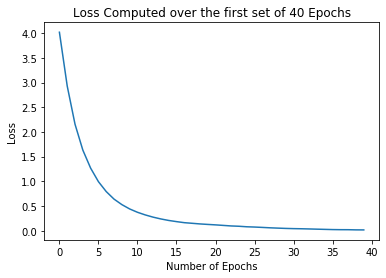

In [43]:
sns.lineplot(data = graph_epochs_first, x = 'Number of Epochs', y = 'Loss' )
plt.title('Loss Computed over the first set of 40 Epochs')

Running the other set of Epochs: Reduce learning rate and step size, increase the batch size
            * Number of Epochs: 25
                    * Number of pic per Batch: 6
                    * Learning Rate: 0.0001
                    * Step Size : 200

In [44]:
loss_vals_second=model_implement(25,6,0.00001,len(train_image_description)//6)

Epoch 1/1
200/200 [==============================] - 47s 236ms/step - loss: 0.0212
dict_keys(['loss'])
********* Current epoch ********** 0
Saved
Epoch 1/1
200/200 [==============================] - 73s 366ms/step - loss: 0.0160
dict_keys(['loss'])
********* Current epoch ********** 1
Saved
Epoch 1/1
200/200 [==============================] - 74s 370ms/step - loss: 0.0138
dict_keys(['loss'])
********* Current epoch ********** 2
Saved
Epoch 1/1
200/200 [==============================] - 74s 370ms/step - loss: 0.0135
dict_keys(['loss'])
********* Current epoch ********** 3
Saved
Epoch 1/1
200/200 [==============================] - 69s 343ms/step - loss: 0.0134
dict_keys(['loss'])
********* Current epoch ********** 4
Saved
Epoch 1/1
200/200 [==============================] - 40s 202ms/step - loss: 0.0120
dict_keys(['loss'])
********* Current epoch ********** 5
Saved
Epoch 1/1
200/200 [==============================] - 41s 205ms/step - loss: 0.0108
dict_keys(['loss'])
********* Current epo

Observing the loss over the Set 2 Epochs

In [45]:
flat_list_second = [item for sublist in loss_vals_second for item in sublist]
epochs = np.arange(0,25)
graph_epochs_second = pd.DataFrame({'Number of Epochs':epochs,'Loss':flat_list_second})

Text(0.5, 1.0, 'Loss Computed over the second set of 25 Epochs')

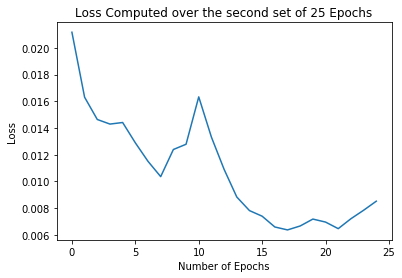

In [46]:
sns.lineplot(data = graph_epochs_second, x = 'Number of Epochs', y = 'Loss' )
plt.title('Loss Computed over the second set of 25 Epochs')

In [47]:
merge_model.load_weights('./merge_model_thesis_weights_08/model_24.h5')

# Classification task for Currency and Pedestrian Signal Detection

In [48]:
currency_map= {0:'five euro', 1:'ten euro',2:'twenty euro',3: 'fifty euro',4:'two hundred euro',5:'five pound',6:'ten pound',7:'twenty pound',8:'fifty pound'}
currency_model = tf.keras.models.load_model('currency_model_final_07.h5')

In [49]:
peds_signal= {0:'red signal', 1:'green signal'}
signal_model = tf.keras.models.load_model('signal_model.h5')

# Generate captions implementing the Greedy Search and Beam Search Approaches

Greedy Search Implementation

In [50]:
def greedy_search_approach(photo):
    start_text = 'startseq'
    for i in range(mx_lng):
        seqnc = []

        for i in start_text.split():
            if i in wordtoindex:
                seqnc.append(wordtoindex[i])
        seqnc = pad_sequences([seqnc], mx_lng)
        y_pred = merge_model.predict([photo,seqnc], verbose=0)
        words = indextoword[np.argmax(y_pred)]
        start_text = start_text + ' ' + words
        if words == 'endseq':
            break
    final_ret = ' '.join(start_text.split()[1:-1])
    return final_ret

Greedy Search Results

In [12]:
greedy_img_seq = 1

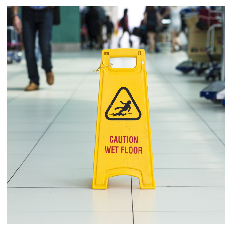

Greedy Search Result: please watch your step wet floor ahead of you


In [669]:
pic = list(encode_test_image.keys())[greedy_img_seq]
im_path = plt.imread(images_path + pic)
greedy_final_image = encode_test_image[pic].reshape((1,2048))
plt.tick_params(bottom=False,left=False)
plt.axis('off')
plt.imshow(im_path)
plt.show()

ans=greedy_search_approach(greedy_final_image)
if "note" in ans:
    curr_img=Image.open(images_path + pic)
    curr_img=curr_img.resize((200,200))
    curr_img=np.expand_dims(curr_img,axis=0)
    temp=currency_model.predict(curr_img)
    choice=temp.flatten().tolist().index(1.0)
    print("Greedy with classification: this is a",currency_map[choice],"note")

elif "signal" in ans:
    sig_img=Image.open(images_path + pic)
    sig_img=sig_img.resize((200,200))
    sig_img=np.expand_dims(sig_img,axis=0)
    temp= signal_model.predict(sig_img)
    choice=temp.flatten().tolist().index(1)
    if choice==0:
        print("Greedy with classification: ",peds_signal[choice],"dont walk")
    elif choice==1:
        print("Greedy with classification: ",peds_signal[choice],"please walk")
else:
    print("Greedy Search Result:",ans)

greedy_img_seq = greedy_img_seq + 1

In [51]:
greedy_eval=[]
encd_test=list(encode_test_image.keys())
test_len=len(list(encode_test_image.keys()))
for leng in range(0,test_len):
    pic = encd_test[leng]
    greedy_final_image = encode_test_image[pic].reshape((1,2048))
    greedy_eval.append(greedy_search_approach(greedy_final_image))

Beam Search Implementation with beam size 2

In [53]:
def beam_search_predictions(images_path, beam_index = 2):
    start = [wordtoindex["startseq"]]
    init_word = [[start, 0.0]]
   
    while len(init_word[0][0]) < mx_lng:
        temp_lst = []
        for strt in init_word:
            partial_captions = sequence.pad_sequences([strt[0]], mx_lng, padding='post')
            array_capts = np.array(partial_captions)
            predct = merge_model.predict([images_path, array_capts])
            predct_word = np.argsort(predct[0])
            predct_word = predct_word[-beam_index:]
            
            for word in predct_word:
                next_cap = strt[0][:]
                prob_cap = strt[1]
                next_cap.append(word)
                predct_tmp = predct[0][word]
                prob_cap = prob_cap + predct_tmp
                temp_lst.append([next_cap, prob_cap])
                    
        init_word = temp_lst
        init_word = sorted(init_word, reverse=False, key=lambda l: l[1])
        init_word = init_word[-beam_index:]
    
    init_word = init_word[-1][0]
    inter_caption = [indextoword[i] for i in init_word]

    final_beam_caption=[]
    for i in inter_caption:
        if i=='endseq':
            break
        else:
            final_beam_caption.append(i)
    
    final_beam_caption = ' '.join(final_beam_caption[1:])
    return final_beam_caption

Beam Search Results

In [13]:
beam_img_seq = 1

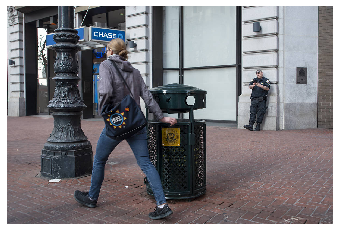

Beam Search Result: please mind your step construction ahead on the street


In [614]:
from PIL import Image
beam_results=[]

beam_pic = list(encode_test_image.keys())[beam_img_seq]
beam_path_pic = plt.imread(images_path + beam_pic)
plt.tick_params(bottom=False,left=False)
plt.axis('off')
plt.imshow(beam_path_pic)
plt.show()
beam_image = encode_test_image[beam_pic].reshape((1,2048))
beam_results.append(beam_search_predictions(beam_image))

ans=beam_search_predictions(beam_image)
if "note" in ans:
    curr_img=Image.open(images_path + beam_pic)
    curr_img=curr_img.resize((200,200))
    curr_img=np.expand_dims(curr_img,axis=0)
    temp=currency_model.predict(curr_img)
    choice=temp.flatten().tolist().index(1.0)
    print("Beam with classification: this is a",currency_map[choice],"note")

elif "signal" in ans:
    sig_img=Image.open(images_path + beam_pic)
    sig_img=sig_img.resize((200,200))
    sig_img=np.expand_dims(sig_img,axis=0)
    temp= signal_model.predict(sig_img)
    choice=temp.flatten().tolist().index(1)
    if choice==0:
        print("Beam with classification: ",peds_signal[choice],"dont walk")
    elif choice==1:
        print("Beam with classification: ",peds_signal[choice],"please walk")
else:
    print("Beam Search Result:",ans)
beam_img_seq = beam_img_seq + 1

In [54]:
beam_eval=[]
test_len=len(list(encode_test_image.keys()))
test_enc=list(encode_test_image.keys())
for leng in range(0,test_len):
    pic = test_enc[leng]
    beam_image = encode_test_image[pic].reshape((1,2048))
    beam_eval.append(beam_search_predictions(beam_image))

# BLEU Score Implementation

In [55]:
def evaluate_bleu_score(reference_captions, predicted_captions):
    actual_caps = []
    for sublist in reference_captions:
        temp = []
        for caption in sublist:
            temp.append(caption.split())
        actual_caps.append(temp)
    
    predicted_caps = []
    for caption in predicted_captions:
        predicted_caps.append(caption.split())
    
    bleu_weights1 = (1.0,0,0,0)
    bleu_weights2 = (0.5,0.5,0,0)
    bleu_weights3 = (0.3,0.3,0.3,0)
    bleu_weights4 = (0.25,0.25,0.25,0.25)
    
    bleu1 = corpus_bleu(actual_caps, predicted_caps, bleu_weights1)
    bleu2 = corpus_bleu(actual_caps, predicted_caps, bleu_weights2)
    bleu3 = corpus_bleu(actual_caps, predicted_caps, bleu_weights3)
    bleu4 = corpus_bleu(actual_caps, predicted_caps, bleu_weights4)
 
    #print('The BLEU-1 Score is {} %.4f'.format(bleu1))
    print('The BLEU-1 Score is %.4f' %bleu1)
    print('The BLEU-2 Score is %.4f' %bleu2)
    print('The BLEU-3 Score is %.4f' %bleu3)
    print('The BLEU-4 Score is %.4f' %bleu4)
   

Creating the reference captions to compare with the predicted captions for evaluating the Bleu Scores

In [56]:
dictn = OrderedDict(sorted(caption.items()))

test_ref_img = []
for test in test_doc1:
    test_ref_img.append(str(test)[0:-4])

my_reference_caps = [caption[key] for key in dictn.keys() if key in test_ref_img]

In [57]:
evaluate_bleu_score(my_reference_caps,greedy_eval)

In [58]:
evaluate_bleu_score(my_reference_caps,beam_eval)

# METEOR Implementation

In [67]:
from nltk.translate.meteor_score import meteor_score
final_meteor_greedy=[]
for i in range(0,len(beam_eval)):
    final_meteor_greedy.append(round(meteor_score(my_reference_caps[i], greedy_eval[i]),4))
print("The METEOR Score for Greedy Search is ",np.array(final_meteor_greedy).mean())

The METEOR Score for Greedy Search is  0.84175


In [68]:
final_meteor_beam=[]
for i in range(0,len(beam_eval)):
    final_meteor_beam.append(round(meteor_score(my_reference_caps[i], beam_eval[i]),1))
print("The METEOR Score for Beam search is ",np.array(final_meteor_beam).mean())

The METEOR Score for Beam search is  0.83924


# Audio Generation

Captions to Audio coversion using gtts text

In [670]:
def audio_gen(my_beam_text):
    language = 'en'
    output = gTTS(text=my_beam_text,lang=language,slow=False)
    output.save("output.mp3")
    os.system("start output.mp3")


# Video Demonstartion on the test Images

In [679]:
image_folder = 'images_cv1'
video_name = 'video.avi'

images_demo = [img for img in os.listdir(image_folder) if img.endswith(".jpg")]
images_demo

frame = cv2.imread(os.path.join(image_folder, images_demo[0]))
height, width, layers = frame.shape

video = cv2.VideoWriter(video_name, 0, 1, (width,height))
frame.shape

(684, 870, 3)

In [680]:
for image in images_demo:
    video.write(cv2.resize(cv2.imread(os.path.join(image_folder, image)),(870,684)))
cv2.destroyAllWindows()
video.release()

In [681]:
demo_dict= {'demo1.jpg':'ATM_queue6.jpg','demo2.jpg':'bench28.jpg','demo3.jpg':'bus35.jpg',
            'demo4.jpg':'chem26.jpg','demo5.jpg':'church5.jpg','demo6.jpg':'Construction4.jpg',
            'demo7.jpg':'door47.jpg','demo8.jpg':'eurofifty_19.jpg','demo9.jpg':'euroten_38.jpg',
            'demo10.jpg':'eurotwenty_40.jpg','demo11.jpg':'eurofive_37.jpg','demo12.jpg':'eurotwohundred_41.jpg',
            'demo13.jpg':'food_street3.jpg','demo14.jpg':'greensig55.jpg','demo15.jpg':'lift15.jpg',
            'demo16.jpg':'luas23.jpg','demo17.jpg':'music19.jpg','demo18.jpg':'play2.jpg',
            'demo19.jpg':'poundfive_37.jpg','demo20.jpg':'push51.jpg','demo21.jpg':'redsig59.jpg',
            'demo22.jpg':'stairsdown_15.jpg','demo23.jpg':'stairsup_1.jpg','demo24.jpg':'tactile10.jpg',
            'demo25.jpg':'trash41.jpg','demo26.jpg':'wait12.jpg','demo27.jpg':'wallet1.jpg',
            'demo28.jpg':'washroom41.jpg','demo29.jpg':'wetfloor46.jpg'}

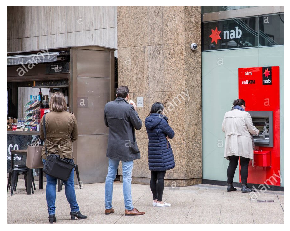

Beam Search: people are in queue at the atm


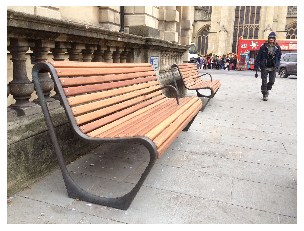

Beam Search: if you want you can relax on the bench ahead of you


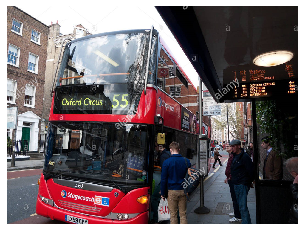

Beam Search: bus has arrived at the bus stop and people are entering the bus


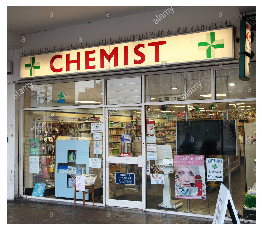

Beam Search: there is a medical shop ahead


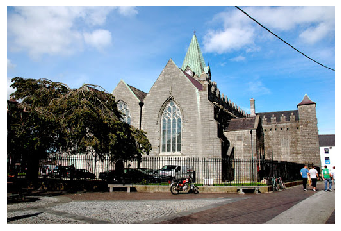

Beam Search: there is a church ahead of you


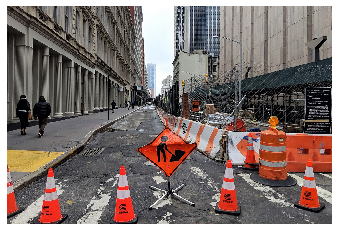

Beam Search: please mind your step construction ahead on the street


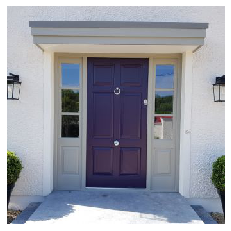

Beam Search: be careful door ahead


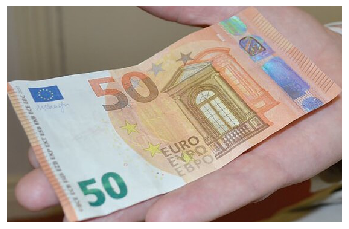

Beam Search: this is a fifty euro note


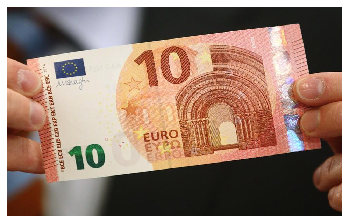

Beam Search: this is a ten euro note


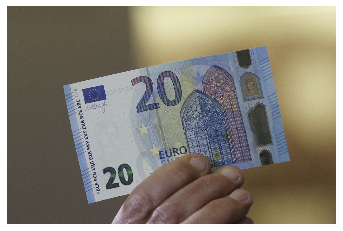

Beam Search: this is a twenty euro note


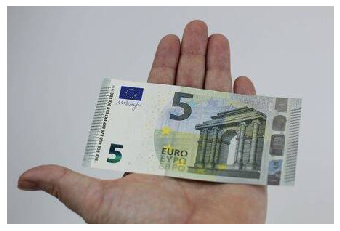

Beam Search: this is a five euro note


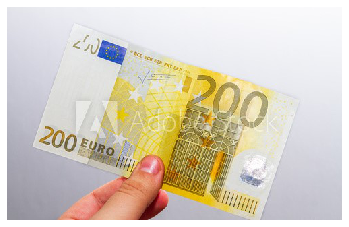

Beam Search: this is a two hundred euro note


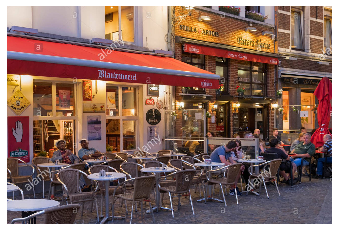

Beam Search: you are approaching towards the outdoor restaurant and can have some snacks


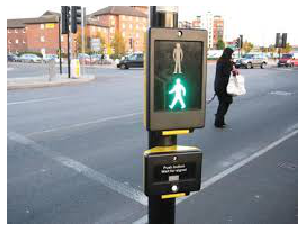

Beam Search: green signal please walk


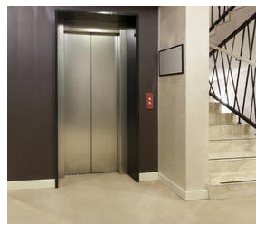

Beam Search: there is a lift ahead


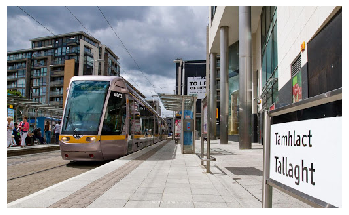

Beam Search: luas has arrived at the stop


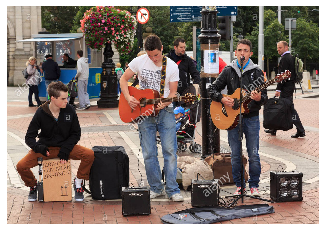

Beam Search: a boy is standing and playing music


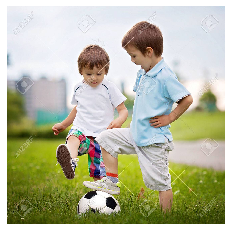

Beam Search: two kids are playing


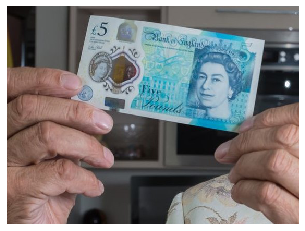

Beam Search: this is a five pound note


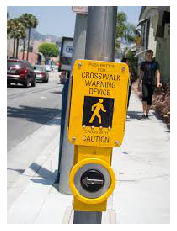

Beam Search: push button ahead press to walk


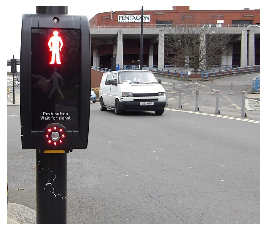

Beam Search: red signal dont walk


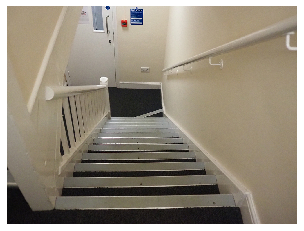

Beam Search: be careful downstairs ahead


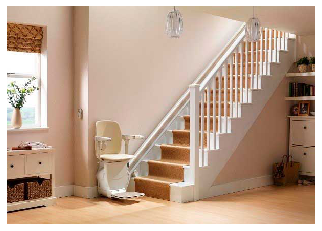

Beam Search: be careful upstairs ahead


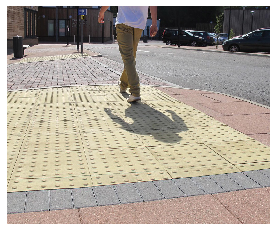

Beam Search: there is a tactile ahead


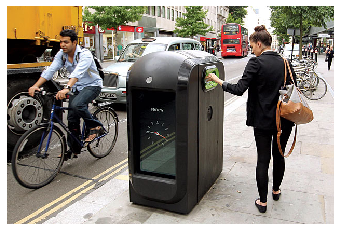

Beam Search: there is a dustbin ahead of you


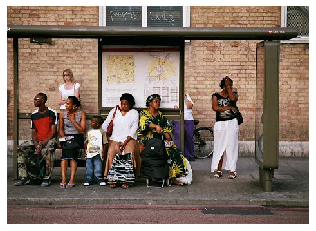

Beam Search: people are waiting at the bus stop


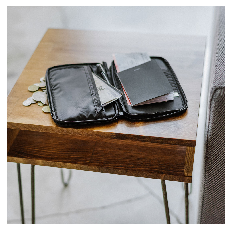

Beam Search: you can pick the wallet from the table


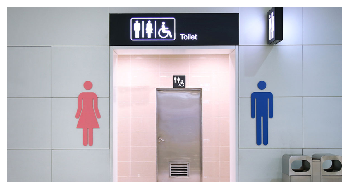

Beam Search: you are approaching towards the restroom


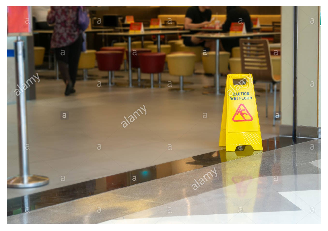

Beam Search: please watch your step wet floor ahead of you


In [682]:
import time
vidcap = cv2.VideoCapture('video.avi')
success,image = vidcap.read()
count = 1
while success:
    cv2.imwrite("demo%d.jpg" % count, image)    
    p=cv2.imread("demo%d.jpg" % count)
    image = encode_test_image[demo_dict["demo%d.jpg" %count]].reshape((1,2048))
    x=plt.imread(images_path+demo_dict["demo%d.jpg" %count])
    plt.tick_params(bottom=False,left=False)
    plt.axis('off')
    plt.imshow(x)
    plt.show()
    print("Beam Search:",beam_search_predictions(image))
    audio_gen(greedy_search_approach(image))
    success,image = vidcap.read()    
    time.sleep(3)
    count += 1
cv2.waitKey(0)
cv2.destroyAllWindows()